In [1]:
## testing printing output from console
import subprocess
cmd = [ 'echo', '"Welcome to my PySpark analysis of some StackOverflow Data"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my PySpark analysis of some StackOverflow Data"\n'


In [2]:
## import standard libraries
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

#%matplotlib inline

In [3]:
import os

In [4]:
# import spark with SparkSession - WORKS!

import findspark # needed on local computer
findspark.init()

import pyspark

spark = (
    pyspark.sql.SparkSession
    .builder
    .master("local[4]") # we can use [X] to limit the number of cores spark uses
    #.config("spark.jars.packages", "com.databricks:spark-xml_2.11:0.4.1")
    .getOrCreate()
)
spark

In [5]:
## check default number of partitions - WORKS!
spark.sparkContext.defaultParallelism

4

In [6]:
'''## import spark with SparkContext() - WORKS!

import findspark # needed on local computer
findspark.init()

import pyspark
#from pyspark.sql import SparkSession

sc = pyspark.SparkContext() # this initiates a spark session

from pyspark.sql import SQLContext
spark = SQLContext(sc) # just renaming for the sake of continuation in notebook

sc'''

'## import spark with SparkContext() - WORKS!\n\nimport findspark # needed on local computer\nfindspark.init()\n\nimport pyspark\n#from pyspark.sql import SparkSession\n\nsc = pyspark.SparkContext() # this initiates a spark session\n\nfrom pyspark.sql import SQLContext\nspark = SQLContext(sc) # just renaming for the sake of continuation in notebook\n\nsc'

In [7]:
'''## check default number of partitions - WORKS for method 2 of importing spark
sc.defaultParallelism'''

'## check default number of partitions - WORKS for method 2 of importing spark\nsc.defaultParallelism'

# Data read-in

In [8]:
%%time

## later will implement for multiple datasets:
data_array = [
    "english",
    #"math",
    #"rus_stackoverflow",
    "stackoverflow",
    #"superuser"
]


datasets = {}    
'''
for i in data_array:
        table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+i+'.stackexchange.com/'+xml_name+'.xml')
        rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x).repartition(96) # key step
        # assign dataframe to list entry
        dfs[i] = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
        dfs[i].createOrReplaceTempView(table_name)
    return dfs
'''

## read in parquet files
for i in data_array:
    datasets[i] = (
        spark
        .read
        .load("initial-data/" + i + ".stackexchange.com/file-01.parquet")
)

CPU times: user 1.86 ms, sys: 2 ms, total: 3.86 ms
Wall time: 3.66 s


In [9]:
datasets["english"].printSchema()
datasets["english"].show(10)

root
 |-- _Body: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- _Score: long (nullable = true)

+--------------------+--------------------+----------+------+
|               _Body|              _Title|_ViewCount|_Score|
+--------------------+--------------------+----------+------+
|<p>How do I know ...|What is the diffe...|     18413|    35|
|<p>When you want ...|Should I use a se...|    106724|    52|
|<blockquote>
  <p...|What does Maugham...|      1131|    11|
|<p>How do you say...|"Adult and childr...|       959|     2|
|<p>"Proven" and "...|What is the diffe...|     52711|    50|
|<p>When reading t...|When is it approp...|      7708|    17|
|<ol>
<li>Are ther...|Identifying Briti...|      5397|    12|
|<p>If I have two ...|In a project, wha...|      1921|     3|
|<p>I understand t...|Is "facebook" as ...|      2759|     3|
|<blockquote>
  <p...| About question tags|      1804|     6|
+--------------------+---------------

In [10]:
def show(df, n=10):
    '''
    function to show spark df entries nicely
    '''
    display(pd.DataFrame(df.head(n), columns=df.columns))

In [11]:
show(datasets["english"])

_Body  \
0  <p>How do I know when to use <em>lay</em> and ...   
1  <p>When you want to connect two closely relate...   
2  <blockquote>\n  <p><strong>Possible Duplicate:...   
3  <p>How do you say it correctly?</p>\n\n<ul>\n<...   
4  <p>"Proven" and "proved" both seem to mean the...   
5  <p>When reading to an audience, or speaking in...   
6  <ol>\n<li>Are there rules of thumb for pinpoin...   
7  <p>If I have two tasks, called "Design" and "D...   
8  <p>I understand that any term, grammatical or ...   
9  <blockquote>\n  <p>He did <strong>nothing*</st...   

                                              _Title  _ViewCount  _Score  
0    What is the difference between "lay" and "lie"?       18413      35  
1  Should I use a semicolon or a dash to connect ...      106724      52  
2    What does Maugham mean by "his spaghetti were"?        1131      11  
3  "Adult and children stories" or "Adults and ch...         959       2  
4  What is the difference between "proven" and "p...       52711      50  
5  When is it appropriate to use the original pro...        7708      17  
6                        Identifying British accents        5397      12  
7  In a project, what is the relationship between...        1921       3  
8  Is "facebook" as a verb different from "google...        2759       3  
9                                About question tags        1804       6

In [12]:
%%time

## number of rows
datasets["english"].count()

CPU times: user 956 µs, sys: 1.78 ms, total: 2.73 ms
Wall time: 472 ms


105475

# Cleaning

In [13]:
'''NEED TO FIX!'''

%%time

## adjust viewcount column so we don't divide by 0

view_count_adj = datasets["english"].view_count+1 # this works

CPU times: user 1.31 ms, sys: 1.91 ms, total: 3.22 ms
Wall time: 388 ms


In [14]:
%%time

## double check that there are no nans

from pyspark.sql.functions import isnan, when, count, col

datasets["stackoverflow_0"].select([count(when(isnan(c), c)).alias(c) for c in datasets["stackoverflow_0"].columns]).show()

+----+-----+----------+-----+-----------------+
|body|title|view_count|score|__index_level_0__|
+----+-----+----------+-----+-----------------+
|   0|    0|         0|    0|                0|
+----+-----+----------+-----+-----------------+

CPU times: user 15.8 ms, sys: 5.24 ms, total: 21.1 ms
Wall time: 4.76 s



# Define response variable

In [15]:
## find average views
datasets["stackoverflow_0"].select("view_count").describe().show() # have to use select here

+-------+------------------+
|summary|        view_count|
+-------+------------------+
|  count|            355203|
|   mean|  2290.24475863098|
| stddev|18940.588708502855|
|    min|                 3|
|    max|           3647865|
+-------+------------------+



In [16]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [17]:
plotly.offline.iplot({
    "data": [go.Histogram(x=datasets["stackoverflow_0"].select("view_count").toPandas()['view_count'])],
    "layout": go.Layout(
        title="Histogram of ViewCount",
        yaxis=dict(
        type='log',
        autorange=True
        )
    )
}) #, auto_open=True, filename='histo-viewcount.html')

In [18]:
## highest view question in data

datasets["stackoverflow_0"].where(datasets["stackoverflow_0"].view_count > 3500000).collect()

[Row(body="<p>I've been using the <code>==</code> operator in my program to compare all my strings so far.\nHowever, I ran into a bug, changed one of them into <code>.equals()</code> instead, and it fixed the bug.</p>\n\n<p>Is <code>==</code> bad? When should it and should it not be used? What's the difference?</p>", title='How do I compare strings in Java?', view_count=3647865, score=727, __index_level_0__=353608)]

In [19]:
## attempt at a cumulative dist plotly plot: 
# https://stackoverflow.com/questions/55220935/plotly-how-to-plot-a-cumulative-steps-histogram


#binned = np.histogram(x, bins=25, density=True)
#plot_y = np.cumsum(binned[0])

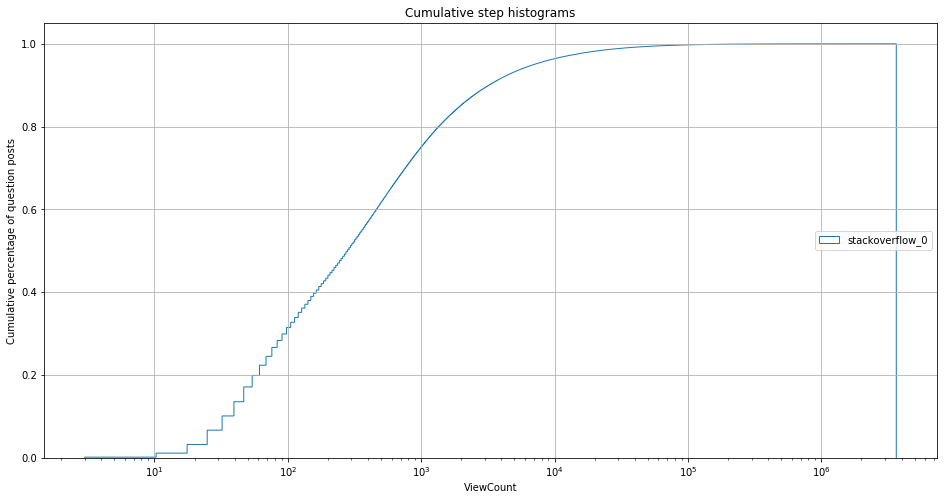

CPU times: user 1.68 s, sys: 215 ms, total: 1.9 s
Wall time: 4.36 s


In [20]:
%%time

## create plot data for cumulative viewcount
plot_data = {}
for i in datasets: # must change to data_array later
    plot_data[i] = datasets[i].select("view_count").rdd.flatMap(lambda x: x).collect()
    #plot_data[i] = [x for x in plot_data[i] if x is not None] don't need this just yet

## plot cumulative distribution of viewcount across fora
n_bins = 500000
fig, ax = plt.subplots(figsize=(16, 8))
for i in datasets: # must change to data array later
    n, bins, patches = ax.hist(plot_data[i], n_bins, density=True, histtype='step',
                               cumulative=True, label=i)
ax.grid(True)
ax.set_xscale('log')
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('ViewCount')
ax.set_ylabel('Cumulative percentage of question posts')
plt.show()

In [ ]:
## find threshold to delete low views to make sure users that can vote have seen the question



thresh <- round(quantile(sxdf_q$ViewCount, .40), -1)
temp <- nrow(sxdf_q)
  # sxdf_q <- sxdf_q[sxdf_q$ViewCount > thresh,]
  # temp <- temp - nrow(sxdf_q)
  # cat("Removed", temp, "questions below chosen threshold of", thresh, "views\n")

# Modeling

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()
X = count_vectorizer.fit_transform(text)
X

In [ ]:
## import elements from natural language toolkit
import nltk
#nltk.download('all') # uncomment first run as admin check
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

In [ ]:
def get_tokens(line):
    '''
    Function to parse text features
    '''
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

In [ ]:
## tokenise and lemmatise using nltk function from import step
body_rdd = {}
for i in data_array:
    body_rdd[i] = body_data[i].map(lambda line: (1, get_tokens(line)))

### LDA Model

In [ ]:
from pyspark.ml.regression import pyspark.ml.clustering.LDA

# Convert notebook to python file

In [31]:
!jupyter nbconvert --to script 1-initial-analysis.ipynb

[NbConvertApp] Converting notebook 1-initial-analysis.ipynb to script
[NbConvertApp] Writing 1747 bytes to 1-initial-analysis.py
